In [1]:
##
## AlexNet analog (Krizhevsky 2012)
##
## 2017-05-20
## maximum on LB => 0.84500
##
## TIF - (,,6) (,,3)
##
## 2017-07-06
##  TIF (64,64,6) - полная схема без выемки 09(cloudy) - то есть 17 признаков
##  
##
##

In [1]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
import sklearn.metrics as skm

from __future__ import print_function

In [2]:
print(np.__version__);
print(pd.__version__);

1.12.1
0.19.2


In [3]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [4]:
sys.path.append('../Python')
from helper import formFH, paths_input

In [5]:
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential,save_model,load_model
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D, MaxPooling1D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
import keras.optimizers
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
import keras.backend as K

Using TensorFlow backend.


In [6]:
keras.__version__

'2.0.4'

In [7]:
trLabels,trDirTIF,trDirJPG,teDirTIF,teDirJPG = paths_input()
trDirI = trDirTIF
teDirI = teDirTIF
trWork, teWork = '../Work/Train', '../Work/Test'
trDirI,teDirI, teDirJPG, trWork, teWork

('../Data/train-tif-v2',
 '../Data/test-tif-v2',
 '../Data/test-jpg-v2',
 '../Work/Train',
 '../Work/Test')

In [8]:
labels_df = pd.read_csv(trLabels)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [9]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [10]:
# Add onehot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
    #labels_df[label].astype(np.int8)
# Display head
#labels_df.head()


In [11]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation' ]
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
#rare_labels              

In [12]:
labels = label_list; #weather_labels;
nameList =labels_df[labels_df[labels].sum(axis=1)>0].image_name.tolist(); len(nameList)
labelList=labels_df[labels_df[labels].sum(axis=1)>0][labels].as_matrix();
labelList[:6,:]
#labels_df.head()

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [13]:
#del(trOX); del(trOY);

In [14]:
##np.save('../Data-Keras/Datas/train-model-2D-128x128x3-XX-not-cloudy.npy',trX)
##np.save('../Data-Keras/Datas/train-model-2D-128x128x3-YY-not-cloudy.npy',trY)

In [15]:
if False :
    ###trXX = np.load('../Data-Keras/Datas/train-model-2D-64x64x6-XX.npy')
    ###trYY = np.load('../Data-Keras/Datas/train-model-2D-64x64x6-YY.npy')
    ######trXX  = np.load('../Data-Keras/Datas/train-model-2D-64x64x3-XX.npy')
    ######trYY  = np.load('../Data-Keras/Datas/train-model-2D-64x64x3-YY.npy')
    trXX  = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-XX.npy')
    trYY  = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-YY.npy')
    ######trXX  = np.load('../Data-Keras/Datas/train-model-2D-224x224x3-XX.npy')
    ######trYY  = np.load('../Data-Keras/Datas/train-model-2D-224x224x3-YY.npy')

    trX, trY = trXX[trYY[:,9]==0], trYY[trYY[:,9]==0] # not cloudy == 9 feature
    trY=trY[:,range(0,9)+range(10,17)] # --cloudy <> 9
    del trXX,trYY
    #print(trXX.shape,trYY.shape)
    print(trX.shape,trY.shape)
if False :
    trX  = np.load('../Data-Keras/Datas/train-model-2D-224x224x3-XX-short.npy')
    trY  = np.load('../Data-Keras/Datas/train-model-2D-224x224x3-YY-short.npy')
    print(trX.shape,trY.shape)
if False :
    trX  = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-XX-not-cloudy.npy')
    trY  = np.load('../Data-Keras/Datas/train-model-2D-128x128x3-YY-not-cloudy.npy')
    print(trX.shape,trY.shape)
    
if True :
    trX  = np.load('../Data-Keras/Datas/train-model-2D-64x64x6-XX-tif.npy')
    trY  = np.load('../Data-Keras/Datas/train-model-2D-64x64x6-YY-tif.npy')
    print(trX.shape,trY.shape)

(40479, 64, 64, 6) (40479, 17)


In [16]:
print(trX.shape,trY.shape)
###del trX, trY

(40479, 64, 64, 6) (40479, 17)


In [17]:
def fbeta_pred(y_true, y_pred, beta=2.0, OK1=0.2, eps=0.000001, printOK=False):
    beta2 = beta*beta
    yy_true = K.round(y_true)
    #yy_pred = K.round(y_pred+(0.5-OK1))
    yy_pred = K.round(y_pred)
    tp, tp_fp, fn = K.sum((yy_pred*yy_true)), K.sum(yy_true), K.sum((K.abs(yy_pred*(yy_true-1.0))))
    precision, recall = tp/(tp_fp+eps), tp/(tp+fn+eps) 
    fbeta = (1+beta2)*(precision*recall)/(beta2*precision+recall+eps)
    ##if fbeta>1.0 : fbeta = 1.0;
    if printOK :
        print('ten true ',K.get_value(yy_true))
        #print('ten pred ',y_pred)
        print('ten roun ',K.get_value(yy_pred))
        print(' pre=',K.get_value(precision),' recall=',K.get_value(recall),' tp=',
              K.get_value(tp),' fn=',K.get_value(fn),' tp+fp=',K.get_value(tp_fp))
    return(fbeta)

In [18]:
#
# model Krizevsky 2012
#
#    input(224x224)
#    c2d(96,(11,11),strides=(4,4))
#    c2d(256,(5,5))
#    c2d(384,(3,3))
#    c2d(384,(3,3))
#    c2d(256,(3,3))
#    maxp(2,2)
#    flaten()
#    dense(4096)
#    dense(4096)
#    dense(output(1000))
#
#
def Kriz2012 ( model, iSize, rSize ) :
    i1,i2,i3 = iSize
    model.add(BatchNormalization(input_shape=(i1,i2,i3)))
    
    model.add(Convolution2D(96,(11,11),strides=(4,4),activation='relu'))
    model.add(Convolution2D(256,(5,5),activation='relu'))
    model.add(Convolution2D(384,(3,3),activation='relu'))
    model.add(Convolution2D(384,(3,3),activation='relu'))
    model.add(Convolution2D(256,(3,3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(4096,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(4096,activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(rSize,activation='sigmoid'))

    return(model)

#
# model Krizevsky 2012
#
#    input(224x224)
#    c2d(96,(11,11),strides=(4,4))
#    c2d(256,(5,5))
#    c2d(384,(3,3))
#    c2d(384,(3,3))
#    c2d(256,(3,3))
#    maxp(2,2)
#    flaten()
#    dense(4096)
#    dense(4096)
#    dense(output(1000))
#
#
def Kriz2012X ( model, iSize, rSize ) :
    i1,i2,i3 = iSize
    model.add(BatchNormalization(input_shape=(i1,i2,i3)))
    
    model.add(Convolution2D(96,(11,11),strides=(4,4),activation='relu'))
    model.add(Convolution2D(256,(5,5),activation='relu'))
    model.add(Convolution2D(384,(3,3),activation='relu'))
    model.add(Convolution2D(384,(3,3),activation='relu'))
    #model.add(Convolution2D(256,(3,3),activation='relu'))
    model.add(Convolution2D(128,(3,3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    #model.add(Dense(4096,activation='relu'))
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.25))
    #model.add(Dense(4096,activation='relu'))
    #model.add(Dropout(0.25))
    
    model.add(Dense(rSize,activation='sigmoid'))

    return(model)

In [19]:
#
# model Krizevsky 2012
#
#    input(224x224)
#    c2d(96,(11,11),strides=(4,4))
#    c2d(256,(5,5))
#    c2d(384,(3,3))
#    c2d(384,(3,3))
#    c2d(256,(3,3))
#    maxp(2,2)
#    flaten()
#    dense(4096)
#    dense(4096)
#    dense(output(1000))
#
# cut version
#
#
def Kriz2012x3x3 ( model, iSize, rSize, cv2d, dense, pp ) :
    i1,i2,i3 = iSize
    model.add(BatchNormalization(axis=3,input_shape=(i1,i2,i3)))
    
    if not (cv2d is None) :
        for cv in cv2d :
            if (cv>0) :
                model.add(Convolution2D(cv,(2,2)))
                #model.add(BatchNormalization(axis=3))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2,2)))
                model.add(Dropout(0.25))

    model.add(Flatten())
    
    if not (dense is None) :
        for de in dense :
            if (de>0) :
                model.add(Dense(pp[5],activation='relu'))
                model.add(Dropout(0.5))
    
    model.add(Dense(rSize,activation='sigmoid'))

    return(model)

In [20]:
def buildModel (iSize,rSize,params=None,cv2d=None,dense=None) :
    model = Sequential()
    if (cv2d is None) and (dense is None) and not (params is None) : cv2d, dense = params[:-2], params[-2:]
    model = Kriz2012x3x3(model,iSize,rSize,cv2d=cv2d,dense=dense,pp=params)
    sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.99, nesterov=True)
    model.compile(loss='mean_absolute_error',  #'binary_crossentropy',
                  optimizer="adam", #sgd, #"adam", #'rmsprop',
                  metrics=[fbeta_pred,'acc']) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    #sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    #model.compile(loss='categorical_crossentropy',
    #              optimizer='adam', #'adam', #sgd, #"adam", #'rmsprop',
    #              metrics=['accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    return(model)

def buildModelKriz (iSize,rSize,params=None,cv2d=None,dense=None) :
    model = Sequential()
    
    model = Kriz2012(model,iSize,rSize)
    #sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.99, nesterov=True)
    sgd = keras.optimizers.SGD(nesterov=True)
    model.compile(loss='binary_crossentropy', # 'mean_absolute_error'
                  optimizer="sgd", #sgd, #"adam", #'rmsprop',
                  metrics=[fbeta_pred,'acc']) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    #sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    #model.compile(loss='categorical_crossentropy',
    #              optimizer='adam', #'adam', #sgd, #"adam", #'rmsprop',
    #              metrics=['accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    return(model)

In [21]:
#mm1=np.sum([K.count_params(p) for p in set(model.trainable_weights)])
#mm2=np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])
#mm1,mm2,mm1+mm2
#len(result),len(resAll)
#trX.shape,trX.dtype,trX[0]
#trY.shape

In [22]:
resAll = []

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience=12,min_delta=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)

params = [(32,64,32,0,0,256,0),(32,64,16,0,0,256,0),(32,64,32,0,0,256,0),(32,64,64,0,0,256,0),(32,64,128,0,0,256,0),(32,64,256,0,0,256,0),(32,64,512,0,0,256,0),(32,64,1024,0,0,256,0)]
params = params+[(32,64,8,0,0,16,0),(32,64,16,0,0,256,0),(32,64,32,0,0,64,0),(32,64,64,0,0,128,0),(32,64,128,0,0,256,0),(32,64,256,0,0,512,0),(32,64,512,0,0,1024,0),(32,64,1024,0,0,2048,0)]
params = params+[(32,64,8,0,0,16,128),(32,64,16,0,0,32,128),(32,64,32,0,0,64,128),(32,64,64,0,0,128,128),(32,64,128,0,0,256,128),(32,64,256,0,0,512,128),(32,64,512,0,0,1024,128),(32,64,1024,0,0,2048,128)]
params = params+[(96,256,384,384,256,4096,4096),(96,256,384,384,256,4096,2048),(96,256,384,384,256,2048,4096),(96,256,384,384,256,2048,2048),
          (96,256,384,384,0,4096,0),(96,256,384,0,256,4096,0),(96,256,0,0,256,4096,0),
          (96,256,0,0,0,4096,0),(96,0,0,0,0,4096,0),(96,256,0,0,256,4096,0)]
#         (96,256,384,197,256,4096,0),  bad unchausted memory ResourceExhaustedError: OOM when allocating tensor with shape[128,8,8,384]
#         (96,128,0,0,0,4096,0),
#
#        [(96,256,197,0,0,4096,0), (96,256,384,384,256,4096,0)]
#
#       [(96,32,0,0,0,1024,0),(96,64,0,0,0,1024,0),(96,128,0,0,0,1024,0),(96,256,0,0,0,1024,0),
#         (256,32,0,0,0,1024,0),(256,64,0,0,0,1024,0),(256,128,0,0,0,1024,0)]

params = [(96,64,0,0,0,256,0),(96,64,0,0,0,512,0),(96,64,0,0,0,1024,0),(96,64,0,0,0,2048,0),(96,64,0,0,0,8192,0)]
params = params+[(16,64,0,0,0,256,0),(32,64,0,0,0,256,0),(64,64,0,0,0,256,0),(128,64,0,0,0,256,0),(256,64,0,0,0,256,0)]

params = [(32,64,16,0,0,256,0)] 
params = [(16,32,64,256,0,512,512),(8,64,256,1024,0,512,512),(8,64,256,1024,0,0,512),(8,64,256,2048,0,0,512),(8,64,256,2048,0,512,512),
          (8,64,256,2048,0,1024,0),(8,64,256,2048,0,1024,1024)]
##params = [(8,64,256,1024,0,512,512),(8,64,256,1024,0,512,0)]
params = [(8,64,256,2048,0,2048,0)] # 0.87 0.87
params = [(8,64,256,4096,0,1024,0)] # 0.8686 0.8724
params = [(32,64,16,0,0,256,512),(8,64,256,2048,0,1024,0),(8,64,256,2048,0,512,0),(8,64,256,4096,0,256,0)] # 0.875 0.8796
params = [(32,64,16,0,0,256,512)]

#params = [(8,64,256,4096,0,256,0)]

iSize, rSize, result = (trX.shape[1],trX.shape[2],trX.shape[3]), trY.shape[1], []
print(iSize,rSize)
epochs  = 100
verbose = 2
batch_size = 64 # 64 0.8633 0.8717 (68 secs/batch) # 32 0.8545 0.8653 (87 secs/batch) # 16 0.8483 0.8623 (137 secs/batch) # 32
for pp in [] : #params :
    filepath="../Data-Keras/weights.{epoch:02d}-{val_loss:.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    model1 = buildModel(iSize,rSize,pp)
    tr1=np.sum([K.count_params(p) for p in set(model1.trainable_weights)])
    tr2=np.sum([K.count_params(p) for p in set(model1.non_trainable_weights)])
    if (tr1+tr2)>14000000 : 
        print(datetime.datetime.now(),pp,tr1+tr2,'(badly)')
        continue;
    print(datetime.datetime.now(),pp,tr1+tr2)
    hist1  = model1.fit(trX,trY,epochs=epochs, batch_size=batch_size, validation_split=0.20, 
                        callbacks=[early_stopping,reduce_lr,checkpoint],
                        verbose=verbose)
    
    trP = model1.predict(trX, batch_size=128)
    fbeta2score=fbeta_score(trY, np.array(trP) > 0.2, beta=2, average='samples')
    fbeta2pred =K.get_value(fbeta_pred(trY.astype(np.float64),trP.astype(np.float64)))
    #print(datetime.datetime.now(),pp,hist1.history['fbeta_pred'][-1],hist1.history['val_fbeta_pred'][-1],'fbeta2s=',fbeta2score,fbeta2pred)
    print(datetime.datetime.now(),pp,'fbeta2s=',fbeta2score,fbeta2pred)
    result.append([pp,hist1])


(64, 64, 6) 17


In [24]:
iSize, rSize, result = (trX.shape[1],trX.shape[2],trX.shape[3]), trY.shape[1], []
params = (32,64,128,256,0,256,512)
print(iSize,rSize)
metric = 'acc'
model10 = buildModelKriz(iSize,rSize,params)

(64, 64, 6) 17


In [25]:
if False :
    sgd = keras.optimizers.SGD(nesterov=True)
    model10.compile(loss= 'binary_crossentropy', 
                #'mean_squared_error', #'mean_absolute_error',  #'binary_crossentropy','categorical_crossentropy',
                  optimizer="rmsprop", #sgd, #"adam", #'rmsprop',
                  metrics=[metric,fbeta_pred]) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])


In [26]:
if False : model10.load_weights('../Data-Keras/Models/model-Alex-weights-128x128x3.h5', by_name=False)

In [43]:
epochs     = 100
verbose    = 2
batch_size = 128
stopping   = 10

prefixTemp = 'tif-64x64x6'     

early_stopping = EarlyStopping(monitor='val_loss', patience=stopping,min_delta=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.00001)

filepath="../Temp/"+prefixTemp+"-weights.{epoch:02d}-acc={"+metric+":.4f}-val_acc={val_"+metric+":.4f}-val_fbeta_pred={val_fbeta_pred:.4f}.hdf5"
##checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#checkpoint = ModelCheckpoint(filepath, monitor='val_'+metric, verbose=1, save_best_only=True, mode='max')
checkpoint = ModelCheckpoint(filepath, monitor=metric, verbose=1, save_best_only=True, mode='max')

tr1    = np.sum([K.count_params(p) for p in set(model10.trainable_weights)])
tr2    = np.sum([K.count_params(p) for p in set(model10.non_trainable_weights)])

step = 25000
low  = 30000
high = low+step

print(datetime.datetime.now(),tr1+tr2)
#hist1  = model10.fit(trX[low:high],trY[low:high],
hist1  = model10.fit(trX[low:high],trY[low:high],
                    epochs=epochs, batch_size=batch_size, 
                    validation_split=0.25, 
                    callbacks=[early_stopping,checkpoint], #,reduce_lr],
                    verbose=verbose)

##trP = model1.predict(trX, batch_size=128)
##fbeta2score=fbeta_score(trY, np.array(trP) > 0.2, beta=2, average='samples')
##fbeta2pred =K.get_value(fbeta_pred(trY.astype(np.float64),trP.astype(np.float64)))
print(datetime.datetime.now()) #,pp,'fbeta2s=',fbeta2score,fbeta2pred)


2017-07-06 13:33:15.618195 24831433
Train on 12000 samples, validate on 3000 samples
Epoch 1/100
Epoch 00000: acc improved from -inf to 0.92417, saving model to ../Temp/tif-64x64x6-weights.00-acc=0.9242-val_acc=0.9257-val_fbeta_pred=0.8054.hdf5
14s - loss: 0.1904 - fbeta_pred: 0.8018 - acc: 0.9242 - val_loss: 0.1868 - val_fbeta_pred: 0.8054 - val_acc: 0.9257
Epoch 2/100
Epoch 00001: acc did not improve
13s - loss: 0.1908 - fbeta_pred: 0.8000 - acc: 0.9235 - val_loss: 0.1868 - val_fbeta_pred: 0.8057 - val_acc: 0.9258
Epoch 3/100
Epoch 00002: acc improved from 0.92417 to 0.92418, saving model to ../Temp/tif-64x64x6-weights.02-acc=0.9242-val_acc=0.9257-val_fbeta_pred=0.8055.hdf5
14s - loss: 0.1907 - fbeta_pred: 0.8024 - acc: 0.9242 - val_loss: 0.1868 - val_fbeta_pred: 0.8055 - val_acc: 0.9257
Epoch 4/100
Epoch 00003: acc improved from 0.92418 to 0.92438, saving model to ../Temp/tif-64x64x6-weights.03-acc=0.9244-val_acc=0.9258-val_fbeta_pred=0.8057.hdf5
14s - loss: 0.1904 - fbeta_pred: 0.8

In [40]:
trX.shape, trY.shape

((40479, 64, 64, 6), (40479, 17))

In [44]:
%time trP = model10.predict(trX, batch_size=batch_size)

CPU times: user 9.22 s, sys: 3.29 s, total: 12.5 s
Wall time: 19.8 s


In [45]:
print(model10.evaluate(trX,trY,verbose=2))
print(trY.shape)
print(trP.shape)
print('fbeta_score=',fbeta_score(trY, np.array(trP) > 0.2, beta=2, average='samples'))
print('fbeta_pred =',K.get_value(fbeta_pred(trY.astype(np.float64),trP.astype(np.float64))))

[0.18526346000299473, 0.80816255649702451, 0.92633072530190497]
(40479, 17)
(40479, 17)
fbeta_score= 0.814773059192
fbeta_pred = 0.807923882932


In [46]:
if True : #False :
    save_model(model10,'../Data-Keras/Models/model-Alex-64x64x6-tif.h5')
    model10.save_weights('../Data-Keras/Models/model-Alex-weights-64x64x6-tif.h5')

In [35]:
model10.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 64, 64, 6)         24        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 96)        69792     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 256)       614656    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 384)         885120    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 384)         1327488   
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 256)         884992    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 256)         0         
__________

In [54]:
trP[0], trY[0]

(array([  4.24685717e-01,   9.46143329e-01,   4.39642975e-03,
          4.20323849e-01,   7.06319138e-02,   8.56452971e-04,
          3.88244563e-03,   2.43555196e-03,   3.76900629e-04,
          2.45276783e-02,   1.58367795e-04,   4.39050957e-04,
          2.17491270e-05,   1.09793269e-03,   9.49518348e-04,
          8.12707702e-04], dtype=float32),
 array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [97]:
# Процедуры для оценки результативности

def confusion_matrix (tTruth, tPredict) :
    tp  = (tTruth==tPredict)&(tTruth==1); tp=len(tp[tp])
    fn  = (tTruth==tPredict)&(tTruth==0); fn=len(fn[fn])
    tn  = (tTruth<>tPredict)&(tTruth==1); tn=len(tn[tn])
    fp  = (tTruth<>tPredict)&(tTruth==0); fp=len(fp[fp])
    return(np.array([[tp,tn],[fp,fn]]))

def getConfusion (tGroundTrue, tPredict) :
    cList = []
    for i in range(tPredict.shape[1]) :
        #cList.append(skm.confusion_matrix(tGroundTrue[:,i],tPredict[:,i]))
        cList.append(confusion_matrix(tGroundTrue[:,i],tPredict[:,i]))
    return(np.array(cList))

def getRocAUC (tGroundTrue, tPredict) :
    rList = []
    for i in range(tPredict.shape[1]) :
        rList.append(skm.roc_auc_score(tGroundTrue[:,i],tPredict[:,i]))
    return(np.array(rList))

In [96]:
print(confusion_matrix(np.array([0,0]),np.array([1,0])).tolist(),
      confusion_matrix(np.array([1,1]),np.array([1,0])).tolist(),
      confusion_matrix(np.array([1,1]),np.array([1,1])).tolist(),
      confusion_matrix(np.array([1,0]),np.array([1,0])).tolist(),
      confusion_matrix(np.array([1,0]),np.array([0,1])).tolist()
      )

[[0, 0], [1, 1]] [[1, 1], [0, 0]] [[2, 0], [0, 0]] [[1, 0], [0, 1]] [[0, 1], [1, 0]]


In [80]:
def getProb01 (trYP, th=0.5) :
    trYY = trYP.copy()
    trYY[trYY<th] = 0
    trYY[trYY>0]  = 1
    return (trYY)

In [81]:
# Построение пределов прохождения для предсказанного
def getTh (tGround,tPredict, prec=100 ) :
    ixx,iacc = [], []
    for i in range(tGround.shape[1]) :
        max, maxxx = 0.0, 0.0
        for xx in range(0,prec+1) :
            tempYP = getProb01(tPredict[:,i],th=(float(xx)/prec)); #print(tPredict[:,1],tempYP[0])
            temp = skm.accuracy_score(tGround[:,i],tempYP)
            #print(float(xx/10.0),temp)
            if (temp>max) : 
                max = temp; maxxx = float(xx)
                temp = skm.confusion_matrix(tGround[:,i],tempYP);
                minloss = temp[0][1]+temp[1][0]
        ixx.append(maxxx)
        tempYP = getProb01 (tPredict[:,i])
        temp = skm.accuracy_score(tGround[:,i],tempYP)
        minloss05 = skm.confusion_matrix(tGround[:,i],tempYP);
        minloss05 = minloss05[0][1]+minloss05[1][0]
        iacc.append((maxxx,max,temp,minloss,minloss05))
    ixx = [float(xx/prec) for xx in ixx]
    return (ixx,iacc)
#ixx, iacc = getTh(trY,trYPP, prec=100)
#np.array(ixx) , iacc

In [66]:
# Посчитать уровень прохождения для каждого признака
ixx, iacc = getTh(trY,trP)
np.array(ixx), iacc

(array([ 0.46,  0.6 ,  0.54,  0.47,  0.41,  0.47,  0.52,  0.45,  0.08,
         0.53,  0.06,  0.22,  0.15,  0.09,  0.11,  0.05]),
 [(46.0, 0.93907267517582704, 0.9390205782755926, 2339, 2341),
  (60.0, 0.97801510810106795, 0.97791091430059907, 844, 848),
  (54.0, 0.84232873144047926, 0.84141703568637671, 6053, 6088),
  (47.0, 0.86962750716332382, 0.86962750716332382, 5005, 5005),
  (41.0, 0.83021620213597291, 0.82430320395936441, 6518, 6745),
  (47.0, 0.91073196144829383, 0.91036728314665283, 3427, 3441),
  (52.0, 0.84355300859598858, 0.8429799426934097, 6006, 6028),
  (45.0, 0.88809585829643134, 0.8872102109924459, 4296, 4330),
  (8.0, 0.99455587392550149, 0.99455587392550149, 209, 209),
  (53.0, 0.90588694972649131, 0.90520969002344365, 3613, 3639),
  (6.0, 0.99739515498827824, 0.99739515498827824, 100, 100),
  (22.0, 0.9777025266996614, 0.97754623599895807, 856, 862),
  (15.0, 0.99119562386038029, 0.99116957541026307, 338, 339),
  (9.0, 0.99135191456108362, 0.99135191456108362, 332,

In [103]:
fresList=[]

In [104]:
print(trY.shape)
fres = []
trP01 = getProb01(trP)
for i in range(trY.shape[1]) :
        cm = confusion_matrix(trY[:,i],trP01[:,i])
        print('{} acc={} roc={} not={} yes={} no={} true={}'.format(i,
              skm.accuracy_score(trY[:,i],trP01[:,i]),
              #skm.accuracy_score(trY[:,i],trP[:,i]),
              skm.roc_auc_score(trY[:,i],trP01[:,i]),
              cm[0,1]+cm[1,0],
              cm[0,0],cm[1,1],
              cm[0,0]+cm[1,1],
             ))
        fres.append ((i,trY.shape[0],
                skm.accuracy_score(trY[:,i],trP01[:,i]),
                #skm.accuracy_score(trY[:,i],trP01[:,i]),
                skm.roc_auc_score(trY[:,i],trP01[:,i]),
                  cm[0,1]+cm[1,0]))
fresList.append(fres)

(38390, 16)
0 acc=0.939020578276 roc=0.651690671637 not=2341 yes=856 no=35193 true=36049
1 acc=0.977910914301 roc=0.542146286285 not=848 yes=37467 no=75 true=37542
2 acc=0.841417035686 roc=0.824618404155 not=6088 yes=9578 no=22724 true=32302
3 acc=0.869627507163 roc=0.8044989363 not=5005 yes=26721 no=6664 true=33385
4 acc=0.824303203959 roc=0.561049983547 not=6745 yes=980 no=30665 true=31645
5 acc=0.910367283147 roc=0.587114768259 not=3441 yes=687 no=34262 true=34949
6 acc=0.842979942693 roc=0.728801270139 not=6028 yes=4292 no=28070 true=32362
7 acc=0.887210210992 roc=0.543269158667 not=4330 yes=424 no=33636 true=34060
8 acc=0.994555873926 roc=0.5 not=209 yes=0 no=38181 true=38181
9 acc=0.905209690023 roc=0.805698250598 not=3639 yes=4688 no=30063 true=34751
10 acc=0.997395154988 roc=0.5 not=100 yes=0 no=38290 true=38290
11 acc=0.977546235999 roc=0.5 not=862 yes=0 no=37528 true=37528
12 acc=0.99116957541 roc=0.5 not=339 yes=0 no=38051 true=38051
13 acc=0.991351914561 roc=0.5 not=332 yes

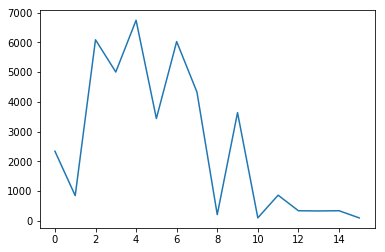

In [106]:
plt.plot([x[4] for x in fresList[-1]]); 
plt.show()

In [31]:
rr, rrx = [], []; trP = model.predict(trX, batch_size=128)
for i in range(trP.shape[1]) :
    xx = [];
    trYY = trY[:,i].astype(np.float64)
    trPY = trP[:,i]
    for ii in range(100) :
        trPP = (trPY>0.01*ii).astype(np.float64)
        #x = fbeta_score(trY[:,0], np.array(trP[:,0] > 0.1*ii), beta=2, average='samples')
        x = K.get_value(fbeta_pred(trYY,trPP))
        xx.append(x)
    rrr = np.array(xx).argmax();
    rr.append(rrr)
    rrx.append(xx[rrr])
    print(datetime.datetime.now(),i,'-->',rrr,xx[rrr],xx[(rrr-1):(rrr+2)])
    #print(xx);
    #plt.plot(np.array(xx)); plt.show()
trM = np.array(rr)/100.0;

2017-05-20 05:22:01.009723 0 --> 70 0.758419290079 [0.75741733368803943, 0.75841929007857778, 0.75785138394714635]
2017-05-20 05:22:23.972821 1 --> 78 0.982638483662 [0.98262473453994426, 0.98263848366246676, 0.98259679666709321]
2017-05-20 05:22:52.632376 2 --> 58 0.847226297632 [0.8469111862002846, 0.84722629763157453, 0.84682213028656683]
2017-05-20 05:23:27.033547 3 --> 78 0.97604678248 [0.97585536488705449, 0.97604678247993626, 0.97586138532621902]
2017-05-20 05:24:07.288213 4 --> 39 0.78729476795 [0.78664609854346335, 0.78729476795032916, 0.78707371492899492]
2017-05-20 05:24:52.980975 5 --> 42 0.789568102568 [0.78871126051941221, 0.78956810256787635, 0.78669767415698355]
2017-05-20 05:25:44.022237 6 --> 47 0.830831644043 [0.8305167161398419, 0.83083164404299403, 0.83015444819651052]
2017-05-20 05:26:40.712293 7 --> 45 0.738016164169 [0.73686966073098015, 0.73801616416924898, 0.73773213859960107]
2017-05-20 05:27:43.679293 8 --> 26 0.676190170231 [0.6690774577597115, 0.6761901702

In [26]:
model.load_weights('../Data-Keras/train-model-2D-2-v2-loop-weights.h5') ## verify load weights from v1 version

In [27]:
# Forming output dataset for predicting --> trOX, trOY
del(trX)
del(trY)

In [34]:
#nameAsk = os.listdir(teDirI); print(len(nameAsk))
nameAsk = os.listdir(teDirJPG); print(len(nameAsk))
trOX, trOY, i, ii, size = [], [], 0, 0, len(nameAsk)
print(datetime.datetime.now(),len(nameAsk),size)
for nn in nameAsk[0:size] :
    #nf = os.path.join(teDirTIF,nn);
    nf = os.path.join(teDirJPG,nn);
    nx = formImExt(nf,resize=(64,64))
    if (nx is not None) :
        trOX.append(nx)
        trOY.append(nn)
    i += 1
    if (i%10000==0) and (i>1) :
        if (ii==0) :
            trOX = np.array(trOX); trOX = trOX / 255.0
            trP = model.predict(trOX, batch_size=512); 
        else :
            trOX = np.array(trOX);  trOX = trOX / 255.0
            trP = np.vstack([trP,model.predict(trOX, batch_size=512)]); 
        trOX,ii = [],ii+1;
    if (i%5000==0) : print(datetime.datetime.now(),"\t",ii,'\t',i,"\t",nn,'\t',(trP.shape if ii>0 else ""))

if (len(trOX)>0) :
    if (ii==0) :
        trOX = np.array(trOX); trOX = trOX / 255.0
        trP = model.predict(trOX, batch_size=512); 
    else :
        trOX = np.array(trOX); trOX = trOX / 255.0
        trP = np.vstack([trP,model.predict(trOX, batch_size=512)]); 
    trOX,ii = [],ii+1;
    
print(datetime.datetime.now())

#assert (size!=len(trOY)), "Wrong files {} != {}".format(size,len(trOY))

61191
2017-05-20 05:46:19.287685 61191 61191
2017-05-20 05:46:38.218814 	 0 	 5000 	 test_14523.jpg 	 
2017-05-20 05:46:51.023731 	 1 	 10000 	 test_19029.jpg 	 (10000, 17)
2017-05-20 05:46:58.884016 	 1 	 15000 	 test_23524.jpg 	 (10000, 17)
2017-05-20 05:47:09.507695 	 2 	 20000 	 test_28015.jpg 	 (20000, 17)
2017-05-20 05:47:16.475888 	 2 	 25000 	 test_32520.jpg 	 (20000, 17)
2017-05-20 05:47:26.837760 	 3 	 30000 	 test_37026.jpg 	 (30000, 17)
2017-05-20 05:47:33.858034 	 3 	 35000 	 test_4908.jpg 	 (30000, 17)
2017-05-20 05:47:44.019579 	 4 	 40000 	 test_9402.jpg 	 (40000, 17)
2017-05-20 05:47:51.298769 	 4 	 45000 	 file_13913.jpg 	 (40000, 17)
2017-05-20 05:48:01.555641 	 5 	 50000 	 file_18419.jpg 	 (50000, 17)
2017-05-20 05:48:24.538867 	 5 	 55000 	 file_4564.jpg 	 (50000, 17)
2017-05-20 05:48:40.785101 	 6 	 60000 	 file_892.jpg 	 (60000, 17)
2017-05-20 05:48:43.863555


In [36]:
#trOX = np.array(trOX);
trOY = np.array([os.path.splitext(x)[0] for x in trOY]);
print(len(nameAsk),trP.shape,trOY.shape)

61191 (61191, 17) (61191,)


In [ ]:
# Saving & Loading

In [26]:
np.save('../Data-Keras/test-basin-2D-64x64-OX-tif-v2.npy',trOX)
np.save('../Data-Keras/test-basin-2D-64x64-OY-tif-v2.npy',trOY)

In [27]:
trOX = np.load('../Data-Keras/test-basin-2D-64x64-OX-tif-v2.npy')
trOY = np.load('../Data-Keras/test-basin-2D-64x64-OY-tif-v2.npy')
print(trOX.shape,trOY.shape)

(61191, 32, 32, 6) (61191,)


In [37]:
rrx
rrd=dict()
for i in range(len(rrx)) :
    rrd[i]=rrx[i]
rrd

{0: 0.75841929007857778,
 1: 0.98263848366246676,
 2: 0.84722629763157453,
 3: 0.97604678247993626,
 4: 0.78729476795032916,
 5: 0.78956810256787635,
 6: 0.83083164404299403,
 7: 0.73801616416924898,
 8: 0.6761901702314258,
 9: 0.86068787363532673,
 10: 0.96403428373772715,
 11: 0.90053737661152566,
 12: 0.6528441526860862,
 13: 0.86359942524081812,
 14: 0.37037005520335736,
 15: 0.68382329252278806,
 16: 0.58917169677281178}

In [258]:
#Forming result

In [30]:
#trP = model.predict(trOX, batch_size=512); 
trP.shape, trP[-1]

((61191, 17), array([  6.56801313e-02,   7.46541142e-01,   2.32726157e-01,
          9.55386758e-01,   1.95543230e-01,   9.11955476e-01,
          8.89197826e-01,   2.53069662e-02,   1.54045611e-05,
          7.43342913e-04,   6.54759035e-02,   6.17289741e-04,
          8.51887614e-02,   2.95602629e-04,   2.64362683e-07,
          1.03749386e-04,   2.92145728e-07], dtype=float32))

In [38]:
trM=np.array([0.0]*len(labels)); print(trM.shape)
wr = [labels.index(i) for i in weather_labels];
tt=trM; trM[:]=0.5
trM[np.array(wr)] = 2.0
print(wr,'\n',labels,'\n',trM.tolist())

(17,)
[3, 10, 0, 9] 
 ['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down'] 
 [2.0, 0.5, 0.5, 2.0, 0.5, 0.5, 0.5, 0.5, 0.5, 2.0, 2.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


In [39]:
#trP = model.predict(trX, batch_size=512); trP=K.get_value(trP)
res = []

for i in range(trP.shape[0]) :
    trPP = [weather_labels[trP[i,wr].argmax()]] + [labels[ii] for ii in range(len(labels)) if (trP[i,ii]>trM[ii])];
    pp   = ' '.join(trPP)
    ##if (pp=="") : print(trY[i])
    res.append([trOY[i],pp])

res.sort(cmp=lambda x,y: cmp(int(x[0].partition('_')[2]),int(y[0].partition('_')[2])) if (x[0].partition('_')[0]==y[0].partition('_')[0]) else cmp(y[0].partition('_')[0],x[0].partition('_')[0]))
#print(res[4:8],'\n',res[-4:])
print(res[0],'\n',res[-1],'\n',trM,trP[0])

['test_0', 'clear primary'] 
 ['file_20521', 'clear primary'] 
 [ 2.   0.5  0.5  2.   0.5  0.5  0.5  0.5  0.5  2.   2.   0.5  0.5  0.5  0.5
  0.5  0.5] [  1.63650557e-01   3.91220033e-01   1.36160061e-01   9.47374701e-01
   9.09343541e-01   1.55211976e-02   3.13203782e-02   1.42206885e-02
   8.06170846e-08   9.10553038e-01   7.85041321e-03   4.12757437e-08
   6.71853591e-03   1.33155788e-06   7.46736941e-06   9.65268737e-06
   7.95199711e-08]


In [40]:
print(labels)
#print(trM.tolist())
#np.round(trP[4:11,:])

['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']


In [41]:
rrr=pd.DataFrame(res,columns=['image_name','tags']); rrr.head(); 
suffixDT = (datetime.datetime.now()).strftime('%Y-%m-%d-%H-%M-%S'); print(suffixDT)
rrr.to_csv('../Result/vss'+suffixDT+'.csv',index=False);

2017-05-20-05-51-18
